### Imports

In [1]:
from glob import glob
from scipy.ndimage import label
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import os
import enum
import json

### Functions

In [2]:
class SegType(enum.Enum):
    NO_LABEL = 0
    GOLD_SEED = 1
    CALCIFICATION = 2

In [3]:
def get_cropped_regions(mask, vals, cropsize=10):
    
    labeled_mask, num_labels = label(
        input=mask,
        structure=np.ones((3, 3, 3))
    )

    cropped_regions = []
    cropped_masks = []

    for region_label in range(1, num_labels+1):
        coords = np.argwhere(labeled_mask == region_label)

        centroid = np.mean(coords, axis=0)
        centroid = np.round(centroid).astype(int)

        half_cropsize = cropsize // 2

        submask = mask[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]
        subvals = vals[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]

        cropped_regions.append(subvals)
        cropped_masks.append(submask)

    return cropped_regions, cropped_masks

In [4]:
def get_region_stats(seg, vals):
    counts = {}
    means = {}
    stds = {}

    for label_id in np.unique(seg):
        if label_id == 0: continue
        
        labels, num_labels = label(
            seg * np.array((seg == label_id), int),
            structure=np.ones((3, 3, 3))
        )

        region_counts = []
        region_means = []
        region_stds = []
        for i in range(1, num_labels+1):
            mask = (labels == i)
            region_counts.append(np.sum(mask))
            region_means.append(np.mean(vals[mask]))
            region_stds.append(np.std(vals[mask]))

        counts[label_id] = region_counts
        means[label_id] = region_means
        stds[label_id] = region_stds

    return counts, means, stds

In [5]:
def update_dict(original_dict, other_dict):
    for key in original_dict:
        if key in other_dict:
            original_dict[key].extend(other_dict[key])
        else:
            original_dict[key] = other_dict[key]
    return original_dict

### Load data

In [6]:
bids_dir = 'bids-new'

session_dirs = []
for json_path in sorted(glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found:")

segmentations = []
qsms = []
for session_dir in session_dirs:
    qsms.extend(glob(os.path.join(session_dir, "extra_data", "*echo2-and-echo4.nii*")))
    segmentations.extend(glob(os.path.join(session_dir, "extra_data", "*seg*clean.nii*")))
print(f"{len(segmentations)} segmentations found.")
print(f"{len(qsms)} QSM images found.")
assert(len(segmentations) == len(qsms))

seed_sizes = []
seed_means = []
seed_stds = []
seed_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(segmentations)):
    # load images
    seg = nib.load(segmentations[i]).get_fdata()
    qsm = nib.load(qsms[i]).get_fdata()

    # get region stats
    counts, means, stds = get_region_stats(seg, qsm)
    print(counts)
    try:
        seed_sizes.extend(counts[SegType.GOLD_SEED.value])
        seed_means.extend(means[SegType.GOLD_SEED.value])
        seed_stds.extend(stds[SegType.GOLD_SEED.value])
        seed_segmentations.extend(os.path.split(segmentations[i])[1] for x in range(len(counts[SegType.GOLD_SEED.value])))
    except:
        print(f"No goldseed found in {segmentations[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegType.GOLD_SEED.value,
        vals=qsm,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([segmentations[i] for x in range(len(connected_regions_vals))])


# create dataframe
seed_data = {
    "size": seed_sizes,
    "mean": seed_means,
    "std": seed_stds,
    "file" : seed_segmentations
}
seed_df = pd.DataFrame(seed_data).sort_values("size")

15 sessions found:
15 segmentations found.
15 QSM images found.
{1.0: [28, 15, 20], 2.0: [35, 1081, 95, 22, 597, 36, 101, 7, 165, 424, 243, 12, 26, 7, 12, 455, 573, 7, 12, 90, 34, 89, 155, 293, 38, 7, 113, 7, 19, 14, 27, 21, 14, 7, 12, 7, 7, 70, 179, 17, 7, 7, 27, 7, 7, 7, 7, 17, 57, 20, 28, 7, 19, 12, 16, 7, 70, 63, 7, 39, 60, 29, 7, 20, 7, 7, 37, 63, 12, 7, 12, 7, 7, 42, 34, 71, 18, 7, 21, 12, 7, 7, 43, 7, 161, 86, 79, 12, 13, 99, 40, 14, 28, 7, 12, 7, 7, 7, 7, 21, 56, 7, 14, 72, 7, 7, 7, 7, 7, 7, 308, 122, 57, 26, 456, 7, 51, 23, 7, 7, 7, 7, 50, 12, 31, 7, 7, 7, 20, 108, 37, 22, 7, 34, 7, 7, 24, 56, 21, 14, 7, 12, 7, 7, 36, 7, 173, 108, 7, 7, 7, 7, 7, 23, 14, 7, 12, 7, 7, 7, 7, 21, 7, 12, 7, 7, 7, 17, 7, 12, 7, 7, 12, 28, 7, 7, 7, 7, 7, 7, 24, 87, 17, 14, 149, 14, 31, 39, 69, 85, 7, 13, 7, 7, 17, 12, 12, 7, 24, 7, 7, 7, 7, 7, 69, 34, 7, 7, 7, 7, 7, 12, 7, 12, 83, 12, 7, 12, 40, 42, 7, 7, 17, 7, 14, 24, 7, 327, 20, 7, 7, 12, 17, 135, 23, 7, 34, 7, 12, 7, 43, 7, 80, 21, 17, 19, 7, 25,

/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


{1.0: [17, 10, 13], 2.0: [431, 7, 17, 67, 12, 1939, 7, 7, 7, 7, 7, 44, 7, 7, 7, 12, 21, 17, 12, 12, 7, 19, 7, 22, 85, 7, 14, 7, 7, 7, 12, 12, 17, 89, 21, 33, 12, 7, 39, 7, 20, 31, 7, 7, 12, 7, 45, 7, 7, 243, 362, 7, 12, 24, 7, 7, 7, 12, 7, 370, 38, 7, 102, 12, 7, 70, 22, 45, 39, 14, 7, 52, 7, 12, 7, 7, 54, 14, 7, 21, 7, 7, 17, 7, 17, 43, 24, 14, 12, 7, 72, 7, 7, 14, 7, 12, 7, 19, 114, 79, 12, 33, 197, 28, 28, 12, 7, 7, 12]}
{1.0: [11, 23, 21], 2.0: [7, 353, 7, 37, 19, 7, 12, 12, 16, 7, 7, 12, 17, 48, 63, 7, 7, 155, 23, 7, 7, 17, 69, 12, 7, 7, 7, 7, 7, 114, 129, 7, 7, 7, 7, 7, 12, 86, 7, 33, 84, 7, 7, 7, 7, 66, 664, 40, 7, 7, 12]}
{1.0: [11, 14, 3], 2.0: [328, 20, 67, 638, 37, 282, 54, 246, 1178, 23, 7, 7, 39, 7, 7, 7, 17, 19, 12, 7, 7, 26, 102, 23, 7, 213, 7, 26, 49, 17, 30, 7, 7, 7, 7, 7, 435, 7, 22, 7, 41, 93, 7, 14, 7, 67, 7, 28, 25, 12, 7, 16, 7, 44, 81, 7, 65, 142, 7, 34, 7, 7, 17, 7, 32, 7, 7, 19, 169, 70, 19, 7, 26, 496, 65, 7, 19, 7, 7, 52, 7, 14, 7, 12, 14, 7, 7, 7, 19, 7, 7, 

### Visualise data

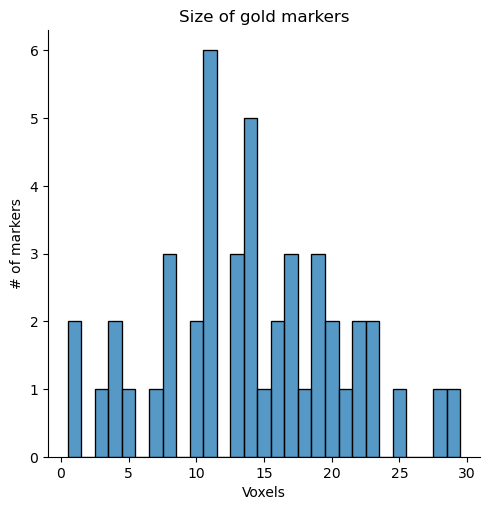

In [7]:
sns.displot(seed_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of markers")
plt.title("Size of gold markers")
plt.savefig("seed_size_histogram.png", bbox_inches='tight')
plt.show()

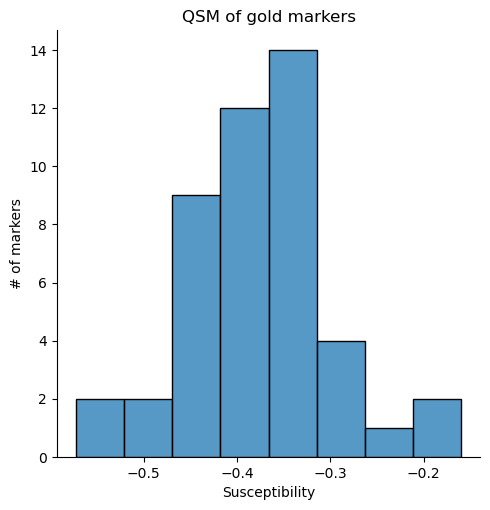

In [8]:
sns.displot(seed_data, x='mean')
plt.xlabel("Susceptibility")
plt.ylabel("# of markers")
plt.title("QSM of gold markers")
plt.savefig("seed_qsm_histogram.png", bbox_inches='tight')
plt.show()

46


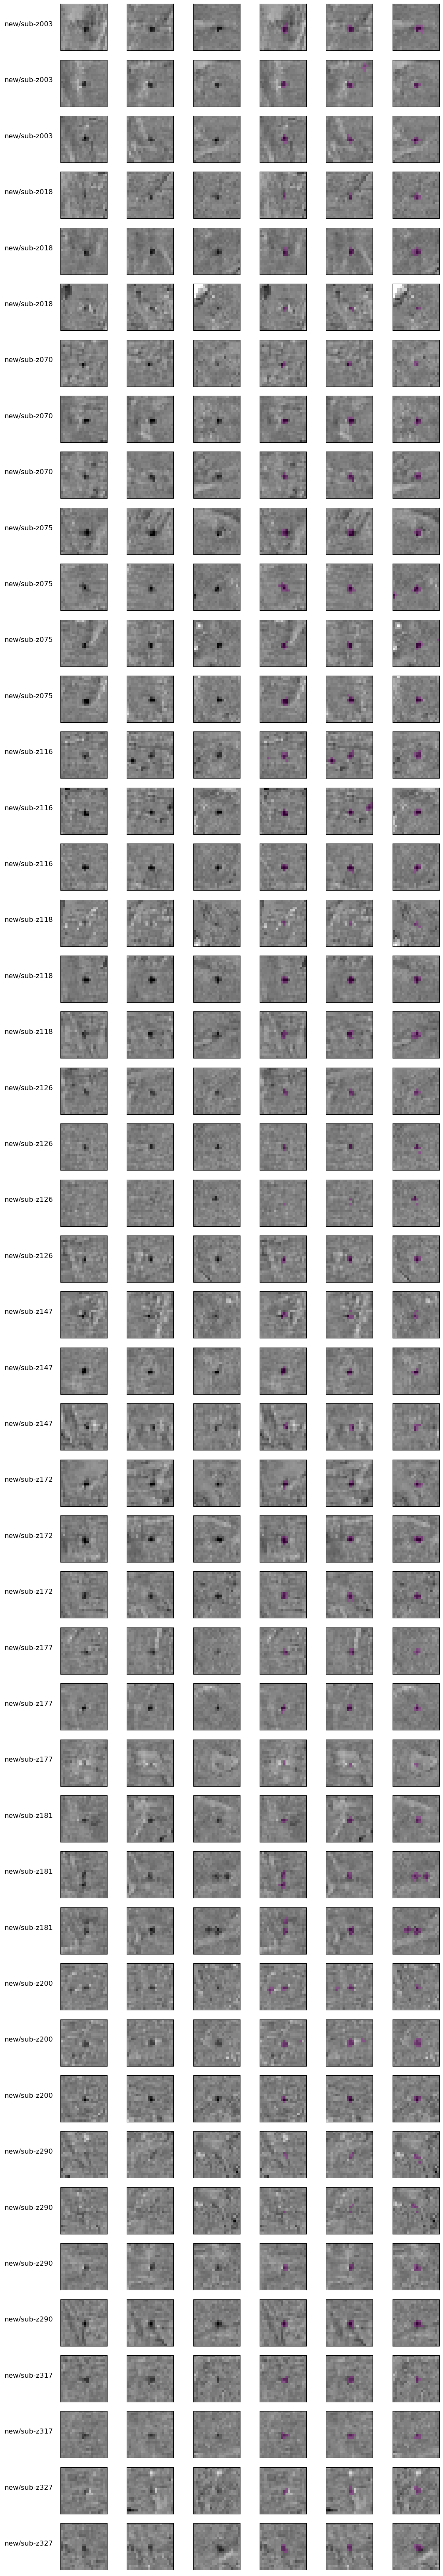

In [9]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

print(len(regions_vals))
for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()

In [16]:
calc_sizes = []
calc_means = []
calc_stds = []
calc_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(segmentations)):
    # load images
    seg = nib.load(segmentations[i]).get_fdata()
    qsm = nib.load(qsms[i]).get_fdata()

    # get region stats
    counts, means, stds = get_region_stats(seg, qsm)
    print(counts)
    try:
        calc_sizes.extend(counts[SegType.CALCIFICATION.value])
        calc_means.extend(means[SegType.CALCIFICATION.value])
        calc_stds.extend(stds[SegType.CALCIFICATION.value])
        calc_segmentations.extend(os.path.split(segmentations[i])[1] for x in range(len(counts[SegType.CALCIFICATION.value])))
    except:
        print(f"No calcification found in {segmentations[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegType.CALCIFICATION.value,
        vals=qsm,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([segmentations[i] for x in range(len(connected_regions_vals))])


# create dataframe
calc_data = {
    "size": calc_sizes,
    "mean": calc_means,
    "std": calc_stds,
    "file" : calc_segmentations
}
calc_df = pd.DataFrame(calc_data).sort_values("size")

{1.0: [28, 15, 20], 2.0: [35, 1081, 95, 22, 597, 36, 101, 7, 165, 424, 243, 12, 26, 7, 12, 455, 573, 7, 12, 90, 34, 89, 155, 293, 38, 7, 113, 7, 19, 14, 27, 21, 14, 7, 12, 7, 7, 70, 179, 17, 7, 7, 27, 7, 7, 7, 7, 17, 57, 20, 28, 7, 19, 12, 16, 7, 70, 63, 7, 39, 60, 29, 7, 20, 7, 7, 37, 63, 12, 7, 12, 7, 7, 42, 34, 71, 18, 7, 21, 12, 7, 7, 43, 7, 161, 86, 79, 12, 13, 99, 40, 14, 28, 7, 12, 7, 7, 7, 7, 21, 56, 7, 14, 72, 7, 7, 7, 7, 7, 7, 308, 122, 57, 26, 456, 7, 51, 23, 7, 7, 7, 7, 50, 12, 31, 7, 7, 7, 20, 108, 37, 22, 7, 34, 7, 7, 24, 56, 21, 14, 7, 12, 7, 7, 36, 7, 173, 108, 7, 7, 7, 7, 7, 23, 14, 7, 12, 7, 7, 7, 7, 21, 7, 12, 7, 7, 7, 17, 7, 12, 7, 7, 12, 28, 7, 7, 7, 7, 7, 7, 24, 87, 17, 14, 149, 14, 31, 39, 69, 85, 7, 13, 7, 7, 17, 12, 12, 7, 24, 7, 7, 7, 7, 7, 69, 34, 7, 7, 7, 7, 7, 12, 7, 12, 83, 12, 7, 12, 40, 42, 7, 7, 17, 7, 14, 24, 7, 327, 20, 7, 7, 12, 17, 135, 23, 7, 34, 7, 12, 7, 43, 7, 80, 21, 17, 19, 7, 25, 7, 7, 12, 17, 7, 7, 12, 7, 52, 7, 74, 20, 7, 17, 7, 18, 7, 7, 7

/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


{1.0: [17, 10, 13], 2.0: [431, 7, 17, 67, 12, 1939, 7, 7, 7, 7, 7, 44, 7, 7, 7, 12, 21, 17, 12, 12, 7, 19, 7, 22, 85, 7, 14, 7, 7, 7, 12, 12, 17, 89, 21, 33, 12, 7, 39, 7, 20, 31, 7, 7, 12, 7, 45, 7, 7, 243, 362, 7, 12, 24, 7, 7, 7, 12, 7, 370, 38, 7, 102, 12, 7, 70, 22, 45, 39, 14, 7, 52, 7, 12, 7, 7, 54, 14, 7, 21, 7, 7, 17, 7, 17, 43, 24, 14, 12, 7, 72, 7, 7, 14, 7, 12, 7, 19, 114, 79, 12, 33, 197, 28, 28, 12, 7, 7, 12]}
{1.0: [11, 23, 21], 2.0: [7, 353, 7, 37, 19, 7, 12, 12, 16, 7, 7, 12, 17, 48, 63, 7, 7, 155, 23, 7, 7, 17, 69, 12, 7, 7, 7, 7, 7, 114, 129, 7, 7, 7, 7, 7, 12, 86, 7, 33, 84, 7, 7, 7, 7, 66, 664, 40, 7, 7, 12]}
{1.0: [11, 14, 3], 2.0: [328, 20, 67, 638, 37, 282, 54, 246, 1178, 23, 7, 7, 39, 7, 7, 7, 17, 19, 12, 7, 7, 26, 102, 23, 7, 213, 7, 26, 49, 17, 30, 7, 7, 7, 7, 7, 435, 7, 22, 7, 41, 93, 7, 14, 7, 67, 7, 28, 25, 12, 7, 16, 7, 44, 81, 7, 65, 142, 7, 34, 7, 7, 17, 7, 32, 7, 7, 19, 169, 70, 19, 7, 26, 496, 65, 7, 19, 7, 7, 52, 7, 14, 7, 12, 14, 7, 7, 7, 19, 7, 7, 

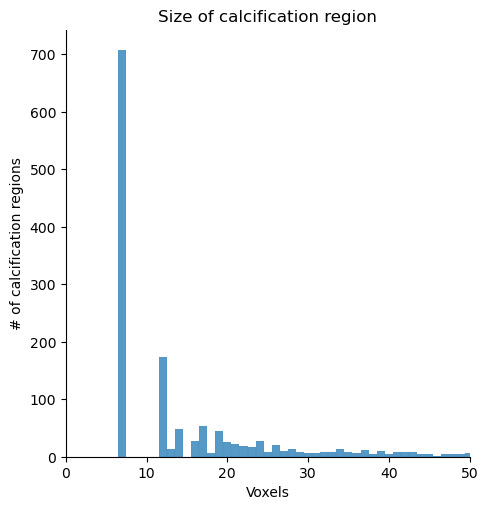

In [21]:
sns.displot(calc_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of calcification regions")
plt.xlim(0, 50)
plt.title("Size of calcification region")
plt.savefig("calc_size_histogram.png", bbox_inches='tight')
plt.show()

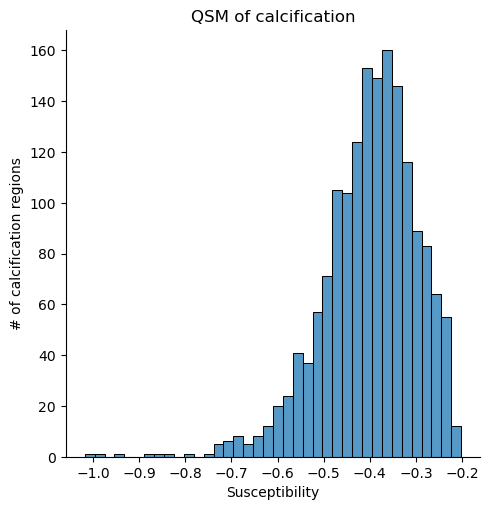

In [18]:
sns.displot(calc_data, x='mean')
plt.xlabel("Susceptibility")
plt.ylabel("# of calcification regions")
plt.title("QSM of calcification")
plt.savefig("calc_qsm_histogram.png", bbox_inches='tight')
plt.show()

In [12]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

print(len(regions_vals))
for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8eef1718b0> (for post_execute):


KeyboardInterrupt: 